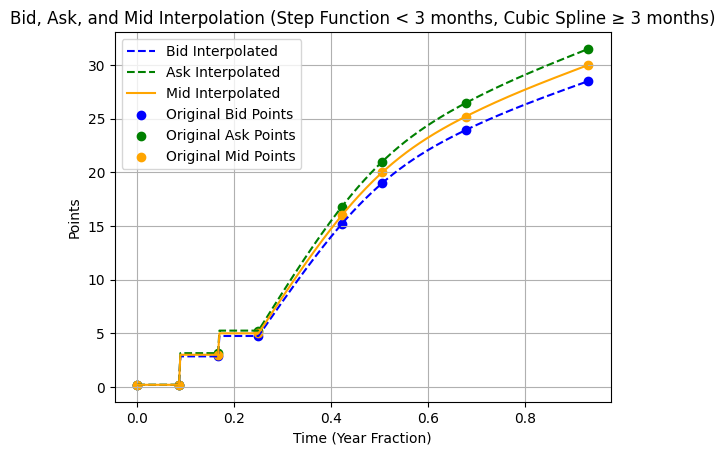

In [11]:
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np

# Example maturities and forward points (months and forward points)
maturities = [ql.Date(1, 1, 2024), ql.Date(1, 2, 2024), ql.Date(1, 3, 2024),
              ql.Date(31, 3, 2024), ql.Date(1, 6, 2024), ql.Date(1, 7, 2024), ql.Date(1, 9, 2024), ql.Date(1, 12, 2024)]

# Forward points to generate bid and ask values
forward_points = [0.2, 0.2, 3, 5, 16, 20, 25.2, 30.0]
bid_points = [p * 0.95 for p in forward_points]
ask_points = [p * 1.05 for p in forward_points]
mid_points = [(bid + ask) / 2 for bid, ask in zip(bid_points, ask_points)]

# Convert maturities to time fractions (year fractions from a reference date)
reference_date = ql.Date(1, 1, 2024)
times = [ql.Actual360().yearFraction(reference_date, m) for m in maturities]

# Helper function to create step and cubic spline interpolations
def create_interpolations(points):
    # Step function for t < 3 months
    step_times = [t for t in times if t <= ql.Actual360().yearFraction(reference_date, ql.Date(31, 3, 2024))]
    step_points = points[:len(step_times)]
    backward_flat_interp = ql.BackwardFlatInterpolation(step_times, step_points)

    # Enable extrapolation for cubic spline
    cubic_times = [t for t in times if t >= ql.Actual360().yearFraction(reference_date, ql.Date(31, 3, 2024))]
    cubic_points = points[len(step_times) - 1:]  # Ensure continuity at 3 months
    cubic_interp = ql.CubicNaturalSpline(cubic_times, cubic_points)

    def interpolate(t):
        if t < ql.Actual360().yearFraction(reference_date, ql.Date(31, 3, 2024)):
            return backward_flat_interp(t)
        else:
            return cubic_interp(t)

    return interpolate

# Create interpolation functions for bid, ask, and mid
bid_interpolate = create_interpolations(bid_points)
ask_interpolate = create_interpolations(ask_points)
mid_interpolate = create_interpolations(mid_points)

# Generate a range of maturities (1 to 12 months) for plotting
maturity_dates = [reference_date + ql.Period(i, ql.Days) for i in range(335)]
maturity_times = [ql.Actual360().yearFraction(reference_date, d) for d in maturity_dates]

# Interpolate bid, ask, and mid points for the range
bid_interpolated_values = [bid_interpolate(t) for t in maturity_times]
ask_interpolated_values = [ask_interpolate(t) for t in maturity_times]
mid_interpolated_values = [mid_interpolate(t) for t in maturity_times]

# Plotting the results to visualize the interpolation for bid, ask, and mid
plt.plot(maturity_times, bid_interpolated_values, label="Bid Interpolated", linestyle='--', color='blue')
plt.plot(maturity_times, ask_interpolated_values, label="Ask Interpolated", linestyle='--', color='green')
plt.plot(maturity_times, mid_interpolated_values, label="Mid Interpolated", color='orange')

# Plot original bid, ask, and mid points
plt.scatter(times, bid_points, color='blue', label="Original Bid Points")
plt.scatter(times, ask_points, color='green', label="Original Ask Points")
plt.scatter(times, mid_points, color='orange', label="Original Mid Points")

plt.title("Bid, Ask, and Mid Interpolation (Step Function < 3 months, Cubic Spline ≥ 3 months)")
plt.xlabel("Time (Year Fraction)")
plt.ylabel("Points")
plt.legend()
plt.grid(True)
plt.show()